In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

os.listdir('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

In [ ]:
imgs = list()
masks = list()

root = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

for fish_name in os.listdir(root):
    if not os.path.isdir(os.path.join(root, fish_name)):
        continue
    
    imgs_dir = os.path.join(root, fish_name, fish_name)
    masks_dir = os.path.join(root, fish_name, fish_name+' GT')
    
    for fn in os.listdir(imgs_dir)[:100]:
        imgs.append(cv2.imread(os.path.join(imgs_dir, fn)))
        
    for fn in os.listdir(masks_dir)[:100]:
        masks.append(cv2.imread(os.path.join(masks_dir, fn)))
        
    print(fish_name)
        
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

axes[0].imshow(imgs[0])
axes[1].imshow(masks[0])

In [ ]:
img_sizes = np.array([img.shape for img in imgs])

for shape, n in zip(*np.unique(img_sizes, axis=0, return_counts=True)):
    print(shape, n)

In [ ]:
X = np.empty((len(imgs), 224, 224, 3))
y = np.empty((len(masks), 224, 224))

for i, img in enumerate(imgs):
    X[i] = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC) / 255
    
for i, mask in enumerate(masks):
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    y[i] = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_CUBIC) / 255

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train.shape, X_val.shape 

In [ ]:
del X

# Conv-DeconvNet

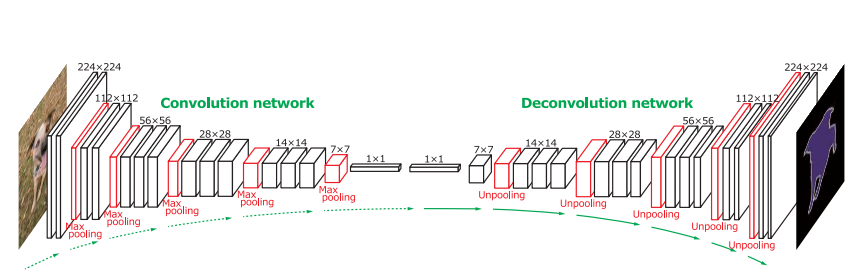

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Flatten

model = Sequential()

# CONV part

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

# DECONV part

model.add(Conv2DTranspose(512, (2, 2), strides=(2, 2), activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

model.add(Conv2DTranspose(256, (2, 2), strides=(2, 2), activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

model.add(Conv2DTranspose(128, (2, 2), strides=(2, 2), activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

model.add(Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))

model.add(Conv2DTranspose(32, (2, 2), strides=(2, 2), activation='relu'))
model.add(Conv2D(32, (1, 1), padding='same', activation='relu'))
model.add(Conv2D(2, (1, 1), padding='same', activation='softmax'))

model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,
                    callbacks=[EarlyStopping(patience=8, restore_best_weights=True), ReduceLROnPlateau(patience=4, factor=0.5)])

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')

axes[1].plot(history.history['accuracy'], label='train_accuracy')
axes[1].plot(history.history['val_accuracy'], label='val_accuracy')

axes[0].legend()
axes[1].legend()

In [ ]:
model.evaluate(X_val, y_val)

In [ ]:
del model

# UNet

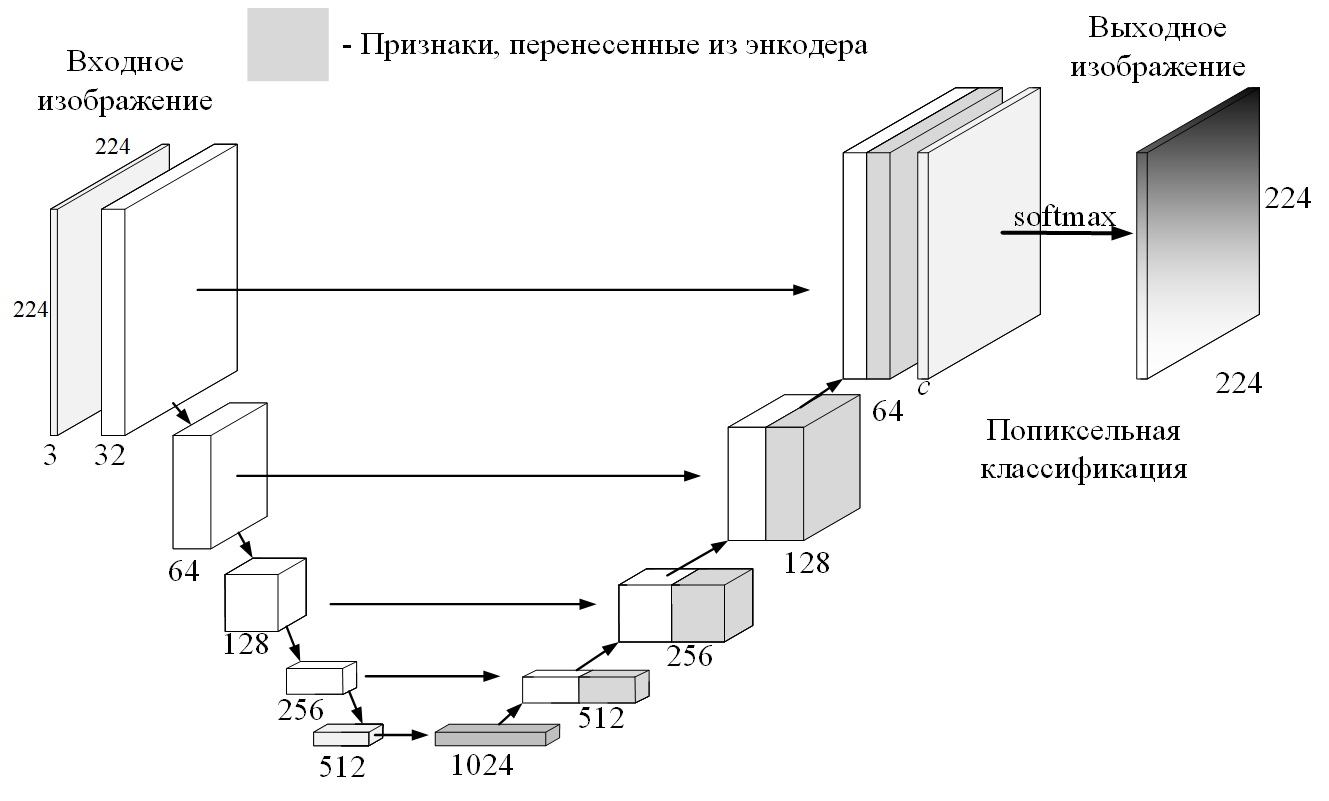

In [ ]:
from tensorflow.keras.layers import Input, Concatenate

inp = Input(shape=(224, 224, 3))

# Conv part

x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(inp)
x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(x1)

x2 = MaxPooling2D((2, 2))(x1) # 112
x2 = Conv2D(64, (3, 3), padding='same', activation='relu')(x2)
x2 = Conv2D(64, (3, 3), padding='same', activation='relu')(x2)

x3 = MaxPooling2D((2, 2))(x2) # 56
x3 = Conv2D(128, (3, 3), padding='same', activation='relu')(x3)
x3 = Conv2D(128, (3, 3), padding='same', activation='relu')(x3)

x4 = MaxPooling2D((2, 2))(x3) # 28
x4 = Conv2D(256, (3, 3), padding='same', activation='relu')(x4)
x4 = Conv2D(256, (3, 3), padding='same', activation='relu')(x4)

x5 = MaxPooling2D((2, 2))(x4) # 14
x5 = Conv2D(512, (3, 3), padding='same', activation='relu')(x5)
x5 = Conv2D(512, (3, 3), padding='same', activation='relu')(x5)

x6 = MaxPooling2D((2, 2))(x5) # 7

# Deconv part

u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), activation='relu')(x6) # 14
u5 = Conv2D(256, (3, 3), padding='same', activation='relu')(u5)
u5 = Conv2D(256, (3, 3), padding='same', activation='relu')(u5)
u5 = Concatenate()([x5, u5])

u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), activation='relu')(u5) # 28
u4 = Conv2D(128, (3, 3), padding='same', activation='relu')(u4)
u4 = Conv2D(128, (3, 3), padding='same', activation='relu')(u4)
u4 = Concatenate()([x4, u4])

u3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu')(u4) # 56
u3 = Conv2D(64, (3, 3), padding='same', activation='relu')(u3)
u3 = Conv2D(64, (3, 3), padding='same', activation='relu')(u3)
u3 = Concatenate()([x3, u3])

u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), activation='relu')(u3) # 112
u2 = Conv2D(32, (3, 3), padding='same', activation='relu')(u2)
u2 = Conv2D(32, (3, 3), padding='same', activation='relu')(u2)
u2 = Concatenate()([x2, u2])

u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), activation='relu')(u2) # 224
u1 = Conv2D(32, (3, 3), padding='same', activation='relu')(u1)
u1 = Conv2D(32, (3, 3), padding='same', activation='relu')(u1)
u1 = Concatenate()([x1, u1])

out = Conv2D(2, (1, 1), padding='same', activation='softmax')(u1)

model = Model(inputs=inp, outputs=out)

model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,
                    callbacks=[EarlyStopping(patience=8, restore_best_weights=True), 
                               ReduceLROnPlateau(patience=4, factor=0.5)])

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')

axes[1].plot(history.history['accuracy'], label='train_accuracy')
axes[1].plot(history.history['val_accuracy'], label='val_accuracy')

axes[0].legend()
axes[1].legend()

In [ ]:
model.evaluate(X_val, y_val)